In [1]:
%reset -f

from functions import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from os import listdir

from PIL import  Image
from sklearn.preprocessing import LabelEncoder
from matplotlib.image import imread
from random import randrange

import cv2 # SIFT

from sklearn import cluster, metrics

%matplotlib inline
%autosave 300

Autosaving every 300 seconds


In [2]:
# Starting time
t0 = time()

input_path = "./dataset/cleaned/"
path_images = "./dataset/images/"
input_filename = "data_images.csv"
input_file = "{}{}".format(input_path, input_filename)

output_path = "./dataset/cleaned/"

In [3]:
list_photos = [file for file in listdir(path_images)]
print(len(list_photos))

1050


In [4]:
data_images = pd.read_csv(input_file)
data_images.head()

,image_path,category,target
0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,Home Furnishing,4
1,7b72c92c2f6c40268628ec5f14c6d590.jpg,Baby Care,0
2,64d5d4a258243731dc7bbb1eef49ad74.jpg,Baby Care,0
3,d4684dcdc759dd9cdf41504698d737d8.jpg,Home Furnishing,4
4,6325b6870c54cd47be6ebfbffa620ec7.jpg,Home Furnishing,4


# PART 1 :

In [5]:
print("TEST")
#img = Image.open(path_images + "0906fd9cc604fbba05a502e01d763cd9.jpg")

# Afficher l'image chargée
#img.show()

TEST


In [6]:
list_labels = data_images["category"].unique().tolist()
list_labels

['Home Furnishing',
 'Baby Care',
 'Watches',
 'Home Decor & Festive Needs',
 'Kitchen & Dining',
 'Beauty and Personal Care',
 'Computers']

In [7]:
display(data_images.groupby("target").count())
print("The data is balanced !")

,image_path,category
target,,
0,150,150
1,150,150
2,150,150
3,150,150
4,150,150
5,150,150
6,150,150


The data is balanced !


## Affichage d'exemples d'images par label

Home Furnishing
-------
For this category, we have 150 images.


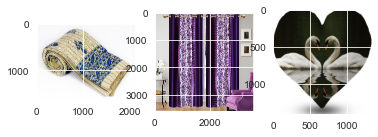

Baby Care
-------
For this category, we have 150 images.


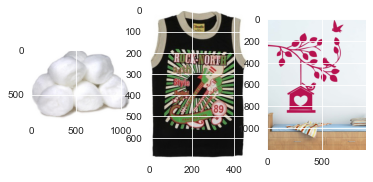

Watches
-------
For this category, we have 150 images.


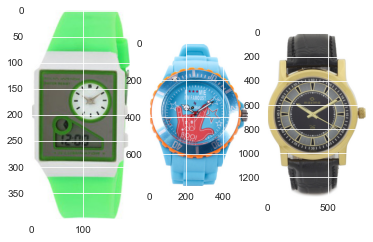

Home Decor & Festive Needs
-------
For this category, we have 150 images.


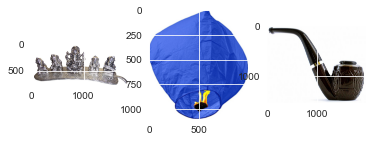

Kitchen & Dining
-------
For this category, we have 150 images.


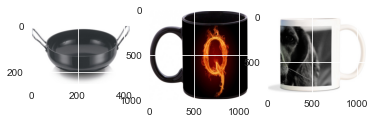

Beauty and Personal Care
-------
For this category, we have 150 images.


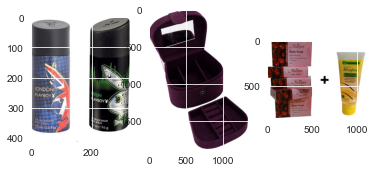

Computers
-------
For this category, we have 150 images.


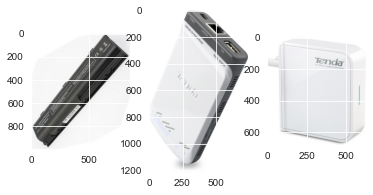

In [8]:
n_categories = len(list_labels)
n_photos = len(list_photos)

def list_fct(category, list_img_in_dir, df, img_column_name, label_column_name) :
    """

    :param category:
    :param list_img_in_dir:
    :param df:
    :param img_column_name:
    :param label_column_name:
    :return:

    :UC: photos in the local directory must match the photos in the dataset df
    """
    list_images_for_a_category = []
    for photo in list_img_in_dir: # 1050 photos in our local directory
        # we get the row in our dataset that matches the photo in the local directory
        img_row = df[df[img_column_name] == photo]
        if (img_row[label_column_name] == category).values[0]: # to np array and get the first element
            list_images_for_a_category.append(photo)
    return list_images_for_a_category



def display_images_per_category(categories, df, path, img_column_name, label_column_name, n_photos_to_display=3):
    """

    :param categories:
    :param df:
    :param path:
    :param img_column_name:
    :param label_column_name:
    :param n_photos_to_display: (from 2 to 9)
    :return:
    """
    for category in categories :
        print(category)
        print("-------")
        # we get the list of photos for one category
        list_photos_cat =  list_fct(category, list_photos, df, img_column_name, label_column_name)
        n = len(list_photos_cat)
        print("For this category, we have", n, "images.")

        for i in range(n_photos_to_display):
            plt.subplot(int('1{}0'.format(n_photos_to_display)) + 1 + i)

            j = randrange(0, n) # from 0 to n-1
            filename = path + list_photos_cat[j] # we choose randomly a photo
            img = imread(filename)
            plt.imshow(img)

        plt.show()

display_images_per_category(list_labels, data_images, path_images, "image_path", "category")

# PART 2 : CNN and Transfert Learning

## 1) CNN

In [9]:
filename = path_images + "893aa5ed55f7cff2eccea7758d7a86bd.jpg"

In [10]:
from keras.applications.vgg16 import VGG16

model = VGG16() # Création du modèle VGG-16 implementé par Keras

In [11]:
from keras_preprocessing.image import load_img, img_to_array
from keras.applications.vgg16 import preprocess_input

img = load_img(filename, target_size=(224, 224))  # Charger l'image
img = img_to_array(img)  # Convertir en tableau numpy
img = img.reshape((1, img.shape[0], img.shape[1], img.shape[2]))  # Créer la collection d'images (un seul échantillon)
img = preprocess_input(img)  # Prétraiter l'image comme le veut VGG-16

In [12]:
y = model.predict(img)  # Prédir la classe de l'image (parmi les 1000 classes d'ImageNet)

1/1 [==============================] - 1s 1s/step


In [13]:
from keras.applications.vgg16 import decode_predictions

# Afficher les 3 classes les plus probables
print('Top 3 :', decode_predictions(y, top=3)[0])

Top 3 : [('n04328186', 'stopwatch', 0.38450032), ('n03706229', 'magnetic_compass', 0.26475736), ('n02708093', 'analog_clock', 0.25344115)]


## 2) Transfert Learning

#### 1) Stratégie : fine-tuning total

In [14]:
for layer in model.layers:
    layer.trainable = True

#### 2) Stratégie : extraction des features

In [15]:
for layer in model.layers:
    layer.trainable = False

#### 3) Stratégie : fine-tuning partiel

In [16]:
# Ne pas entraîner les 5 premières couches (les plus basses)
for layer in model.layers[:5]:
    layer.trainable = False

#### Conclusion TL : compile puis fit !

In [17]:
# Compiler le modèle
new_model.compile(loss="categorical_crossentropy", optimizer=optimizers.SGD(lr=0.0001, momentum=0.9), metrics=["accuracy"])

# Entraîner sur les données d'entraînement (X_train, y_train)
model_info = new_model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=2)


NameError: name 'new_model' is not defined

In [ ]:
# End of notebook time
t1 = time()
print("computing time : {:8.6f} sec".format(t1 - t0))
print("computing time : " + strftime('%H:%M:%S', gmtime(t1 - t0)))